# 

In [1]:
%time
## let's import the relevant libraries
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os
from mpl_toolkits.mplot3d import Axes3D
import pickle
from torchsummary import summary
import scipy.integrate as sciint


## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")
#print(device)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


In [2]:
#import neurodiffeq
from neurodiffeq.neurodiffeq import diff # the differentiation operation
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D # the initial condition
from neurodiffeq.networks import FCNN, SinActv
#from neurodiffeq.ode import solve # the ANN-based solver

#diff = neurodiffeq.neurodiffeq.diff
#Solver1D = neurodiffeq.solvers.Solver1D
#Solver2D = neurodiffeq.solvers.Solver2D
#IVP = neurodiffeq.conditions.IVP
#irichletBVP2D = neurodiffeq.conditions.DirichletBVP2D
#FCNN = neurodiffeq.networks.FCNN
#SinActv = neurodiffeq.networks.SinActv
#solve = neurodiffeq.ode.solve

### Systems of ODE : Lotka–Volterra equations

$$\begin{align}
\frac{du}{dt} = \alpha u - \beta uv \\
\frac{dv}{dt} = \delta uv - \gamma v
\end{align}$$

Let $\alpha = \beta = \delta = \gamma = 1$. Here we solve this pair of ODE when $u(0) = 1.5$ and $v(0) = 1.0$.


In [9]:
# old version


"""# specify the ODE system and its parameters
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda u, v, t : [ diff(u, t) - (alpha*u  - beta*u*v), 
                                    diff(v, t) - (delta*u*v - gamma*v), ]
# specify the initial conditions
init_vals_lv = [
    IVP(t_0=0.0, u_0=1.5),  # 1.5 is the value of u at t_0 = 0.0
    IVP(t_0=0.0, u_0=1.0),  # 1.0 is the value of v at t_0 = 0.0
]

# specify the network to be used to approximate each dependent variable
# the input units and output units default to 1 for FCNN
nets_lv = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv),
    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv)
]

# solve the ODE system
solution_lv, _ = solve_system(
    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12, 
    nets=nets_lv, max_epochs=3000,
    monitor=Monitor1D(t_min=0.0, t_max=12, check_every=100)
)"""

'# specify the ODE system and its parameters\nalpha, beta, delta, gamma = 1, 1, 1, 1\nlotka_volterra = lambda u, v, t : [ diff(u, t) - (alpha*u  - beta*u*v), \n                                    diff(v, t) - (delta*u*v - gamma*v), ]\n# specify the initial conditions\ninit_vals_lv = [\n    IVP(t_0=0.0, u_0=1.5),  # 1.5 is the value of u at t_0 = 0.0\n    IVP(t_0=0.0, u_0=1.0),  # 1.0 is the value of v at t_0 = 0.0\n]\n\n# specify the network to be used to approximate each dependent variable\n# the input units and output units default to 1 for FCNN\nnets_lv = [\n    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv),\n    FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=SinActv)\n]\n\n# solve the ODE system\nsolution_lv, _ = solve_system(\n    ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12, \n    nets=nets_lv, max_epochs=3000,\n    monitor=Monitor1D(t_min=0.0, t_max=12, check_every=100)\n)'

/home/weerachai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Training Progress:   0%|                               | 0/3000 [00:00<?, ?it/s]

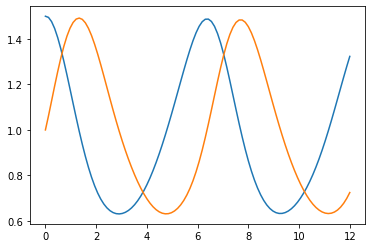

In [3]:
# new version


def ode_system(u, v, t): 
#    print(type(t))
    return [diff(u,t)-(u-u*v), diff(v,t)-(u*v-v)]

conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0)]
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]

solver = Solver1D(ode_system, conditions, t_min=0.1, t_max=12.0, nets=nets)
solver.fit(max_epochs=3000)
solution = solver.get_solution()

#plot
t = np.linspace(0, 12, 100)
u, v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.plot(t,v)
plt.show()

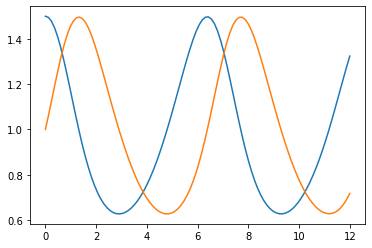

In [11]:
t = np.linspace(0, 12, 100)
u, v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.plot(t,v)
plt.show()

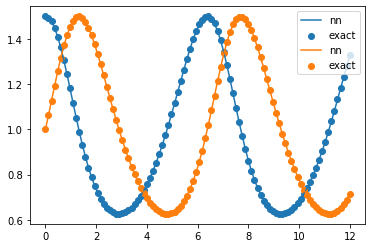

In [12]:
from scipy.integrate import odeint

#normal solve

def dPdt(P, t):
    return [P[0] - P[0]*P[1], P[0]*P[1] - P[1]] # u-uv , uv-v
P0 = [1.5, 1.0]
Ps = odeint(dPdt, P0, t)
u_e = Ps[:,0]
v_e = Ps[:,1]

plt.plot(t, u,label = 'nn')
plt.scatter(t, u_e,label = 'exact')
plt.plot(t, v,label = 'nn')
plt.scatter(t, v_e,label = 'exact')
plt.legend()
plt.show()

In [13]:
mpl = 2.435e27
ad = 1
a = 1
phi = 1
phid = 1
phidd = 1
m = 1
rhom = 1
rhor = 1
ad**2 - (1/(3*mpl**2)) * ((0.5*a**2*phid**2) + (0.5*m**2*a**2*phi**2) + (rhom/a) + (rhor/(a**2)))
phidd + np.sqrt(3)/mpl * (np.sqrt(0.5*phid**2 + 0.5*m**2*phi**2 + rhom/a**3 + rhor/a**4))*phid + m**2*phi

2.0

In [14]:
print()

equation
$$ \dot{a}^2 - \frac{1}{3m^2_{pl}}\left( \frac{1}{2}a^2\dot{\phi}^2_{a} + \frac{1}{2}m^2_aa^2\phi^2_a + \frac{\rho_{m,0}}{a} + \frac{\rho_{r,0}}{a^2} \right) = 0 $$
$$ \ddot{\phi}_a + \frac{\sqrt{3}}{m_{pl}}\left( \sqrt{\frac{1}{2} \dot{\phi}_a^2 + \frac{1}{2}m^2_a\phi_a^2 + \frac{\rho_{m,0}}{a^3} + \frac{\rho_{r,0}}{a^4} }\right)\dot{\phi}_a + m^2_a\phi_a = 0 $$

In [15]:
conditions = [1, 1]
t = np.linspace(0, 12, 100)
n = 9
ln = 3*n + 1
nets = []
for i in range(ln):
    nets.append(i)
print(nets)
def ode_system(nets, t):
    z = []
    u = []
    v = []
    w = []
    for i in range(n):
        z.append(nets[-1])
        u.append(nets[3*i])
        v.append(nets[3*i+1])
        w.append(nets[3*i+2])
#    print(z)
    return u,v,w,z
#    return [diff(u,t)-(u-u*v), diff(v,t)-(u*v-v)]
print(ode_system(nets,t))
#print(ln)
#print((nets[0]))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
([0, 3, 6, 9, 12, 15, 18, 21, 24], [1, 4, 7, 10, 13, 16, 19, 22, 25], [2, 5, 8, 11, 14, 17, 20, 23, 26], [27, 27, 27, 27, 27, 27, 27, 27, 27])


Training Progress:   0%|                               | 0/3000 [00:00<?, ?it/s]

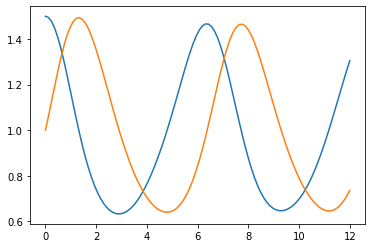

In [9]:
# new version

def ode_system(u,v,t):
    return [diff(u,t)-(u-u*v), diff(v,t)-(u*v-v)]

#    return [diff(x[0],t)-(x[0]-x[0]*x[1]), diff(x[1],t)-(x[0]*x[0]-x[1])]

conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0)]
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]


solver = Solver1D(ode_system, conditions, t_min=0.1, t_max=12.0, nets=nets)
solver.fit(max_epochs=3000)
solution = solver.get_solution()

#plot
t = np.linspace(0, 12, 100)
u, v = solution(t, to_numpy=True)  # t can be np.ndarray or torch.Tensor
plt.plot(t,u)
plt.plot(t,v)
plt.show()

In [17]:
solver

In [15]:
x = u,v,t

In [16]:
print(*x)

[1.5        1.49515786 1.4763411  1.44555169 1.4047766  1.35597564
 1.30106415 1.24189142 1.18021552 1.11767621 1.05576725 0.99581032
 0.93893274 0.88605104 0.8378624  0.79484535 0.75727012 0.72521846
 0.6986114  0.67724298 0.66081716 0.64898497 0.64137916 0.63764398
 0.6374583  0.64055127 0.64671033 0.65578217 0.66766791 0.68231402
 0.69970059 0.71982882 0.74270869 0.76834804 0.79674292 0.82786925
 0.86167467 0.89806979 0.93691764 0.97802074 1.02110572 1.06580625
 1.11164617 1.158025   1.20420909 1.24933111 1.29240073 1.33232815
 1.36796103 1.39813415 1.42172945 1.43774266 1.44535182 1.44398152
 1.43335686 1.41354095 1.38495086 1.34834876 1.30480738 1.25565182
 1.20238252 1.14658662 1.08984641 1.03365362 0.97933737 0.9280115
 0.88054408 0.83754937 0.79939952 0.76625201 0.73808741 0.71475233
 0.69600277 0.68154432 0.67106663 0.66427099 0.66089044 0.66070303
 0.66353867 0.66928067 0.67786287 0.68926304 0.70349346 0.72058909
 0.74059395 0.76354639 0.78946361 0.81832658 0.85006595 0.88455

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# กำหนดฟังก์ชัน ODE system สำหรับ n ตัวแปร
def ode_system(vars, t, n):
    derivatives = []
    for i in range(n):
        if i == 0:
            derivatives.append(diff(vars[i],diff[i+1]) - (vars[i] - vars[i] * vars[i+1]))
        elif i == n - 1:
            derivatives.append(diff(vars[i],vars[i-1]) - (vars[i] - vars[i-1] * vars[i]))
        else:
            derivatives.append(vars[i] * vars[i-1] - vars[i] * vars[i+1])
    return derivatives

# การกำหนดค่าเริ่มต้น
n = 2  # จำนวนตัวแปร
#initial_conditions = [1.0] * n
initial_conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0)]
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]
# เวลาที่จะคำนวณ
t = np.linspace(0, 10, 100)

# การแก้สมการ ODE
solver = Solver1D(ode_system, initial_conditions, t_min=0.1, t_max=12.0, nets=nets)
solver.fit(max_epochs=3000)
solution = solver.get_solution()

# แยกค่าของตัวแปรจากผลลัพธ์
solutions = [solution[:, i] for i in range(n)]

# แสดงผลลัพธ์
for i, sol in enumerate(solutions):
    plt.plot(t, sol, label=f'var{i+1}(t)')

plt.legend()
plt.xlabel('Time t')
plt.ylabel('Values of variables')
plt.show()


Training Progress:   0%|                               | 0/3000 [00:00<?, ?it/s]

TypeError: only integer tensors of a single element can be converted to an index

In [2]:
solutions

[array([1.50000000e+00, 1.50377194e+00, 1.51494685e+00, 1.53347057e+00,
        1.55948018e+00, 1.59329089e+00, 1.63539176e+00, 1.68644813e+00,
        1.74730971e+00, 1.81902284e+00, 1.90284634e+00, 2.00026959e+00,
        2.11303151e+00, 2.24313865e+00, 2.39288021e+00, 2.56483755e+00,
        2.76188537e+00, 2.98718261e+00, 3.24415210e+00, 3.53645080e+00,
        3.86793568e+00, 4.24263443e+00, 4.66473340e+00, 5.13859603e+00,
        5.66882176e+00, 6.26034800e+00, 6.91858737e+00, 7.64958379e+00,
        8.46016647e+00, 9.35808468e+00, 1.03521160e+01, 1.14521515e+01,
        1.26692715e+01, 1.40158249e+01, 1.55055255e+01, 1.71535712e+01,
        1.89767862e+01, 2.09937874e+01, 2.32251712e+01, 2.56937241e+01,
        2.84246539e+01, 3.14458483e+01, 3.47881590e+01, 3.84857165e+01,
        4.25762794e+01, 4.71016197e+01, 5.21079483e+01, 5.76463889e+01,
        6.37734976e+01, 7.05518436e+01, 7.80506458e+01, 8.63464787e+01,
        9.55240569e+01, 1.05677101e+02, 1.16909292e+02, 1.293353

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from neurodiffeq.neurodiffeq import diff, safe_diff
from neurodiffeq.solvers import Solver1D
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN, SinActv

# ปรับฟังก์ชัน deriv_wfromphi
def deriv_wfromphi(vars, t, n, n_cross, ma_array, rho_m0, rho_r0, rhol):
    rho_ax = sum(vars[2::3])
    func = []

    for i in range(n):
        if i == 0:
            func.append(diff(vars[i], t))
        else:
            func.append(vars[i] * vars[i-1] - vars[i] * vars[i+1])

        if i == 0:
            func.append(safe_diff(vars[i], vars[i+1]) - (vars[i] - vars[i] * vars[i+1]))
        elif i == n - 1:
            func.append(safe_diff(vars[i], vars[i-1]) - (vars[i] - vars[i-1] * vars[i]))
        else:
            func.append(vars[i] * vars[i-1] - vars[i] * vars[i+1])

    func.append(1 / np.sqrt(3) * np.sqrt(rho_ax * vars[-1]**2 + rho_m0 / vars[-1] + rho_r0 / vars[-1]**2 + rhol * vars[-1]**2))
    return func

# การกำหนดค่าเริ่มต้น
n = 2  # จำนวนตัวแปร
phiin_array = [1.0, 0.5]  # ค่าเริ่มต้นของ phi
phidotin_array = [0.1, 0.2]  # ค่าเริ่มต้นของ phidot
ma_array = [1.0, 0.5]  # ค่ามวลของ axion
ain = 1.0  # ค่าเริ่มต้นของ a
rho_m0 = 0.3  # ค่าเริ่มต้นของ rho_matter
rho_r0 = 0.2  # ค่าเริ่มต้นของ rho_radiation
rhol = 0.7  # ค่าเริ่มต้นของ rho_lambda
n_cross = 2  # จำนวนครั้งของการ crossing

initial_conditions = [IVP(t_0=0.0, u_0=1.5), IVP(t_0=0.0, u_0=1.0)]
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]

# ฟังก์ชันครอบที่ส่งอาร์กิวเมนต์เพิ่มเติมไปยัง deriv_wfromphi
def wrapped_deriv_wfromphi(vars, t):
    return deriv_wfromphi(vars, t, n, n_cross, ma_array, rho_m0, rho_r0, rhol)

# การแก้สมการ ODE
solver = Solver1D(
    ode_system=wrapped_deriv_wfromphi,
    conditions=initial_conditions,
    t_min=0.0,
    t_max=10.0,
    nets=nets
)
solver.fit(max_epochs=3000)
solution = solver.get_solution()

# เวลาที่จะคำนวณ
t = np.linspace(0, 10, 100)
solutions = [solution(t, i) for i in range(n)]

# แสดงผลลัพธ์
for i, sol in enumerate(solutions):
    plt.plot(t, sol, label=f'var{i+1}(t)')

plt.legend()
plt.xlabel('Time t')
plt.ylabel('Values of variables')
plt.show()


Training Progress:   0%|                               | 0/3000 [00:00<?, ?it/s]

TypeError: wrapped_deriv_wfromphi() takes 2 positional arguments but 3 were given

In [1]:
from neurodiffeq import diff
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN
from neurodiffeq.solvers import Solver1D
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
from neurodiffeq.conditions import IBVP1D
from neurodiffeq.pde import make_animation
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:

l = 0.5
u_0 = 0.1


def ode_exponential(u, t):
    return [diff(u, t) - l*u,]

condition = [IVP(t_0=0, u_0=u_0),]

net = [FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(1024,1024),
    actv=torch.nn.Tanh
),]

solver_exponential = Solver1D(
    ode_system=ode_exponential,
    conditions=condition,
    t_min=0.0,
    t_max=5.0,
    nets=net
)

/home/weerachai/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


<IPython.core.display.Javascript object>


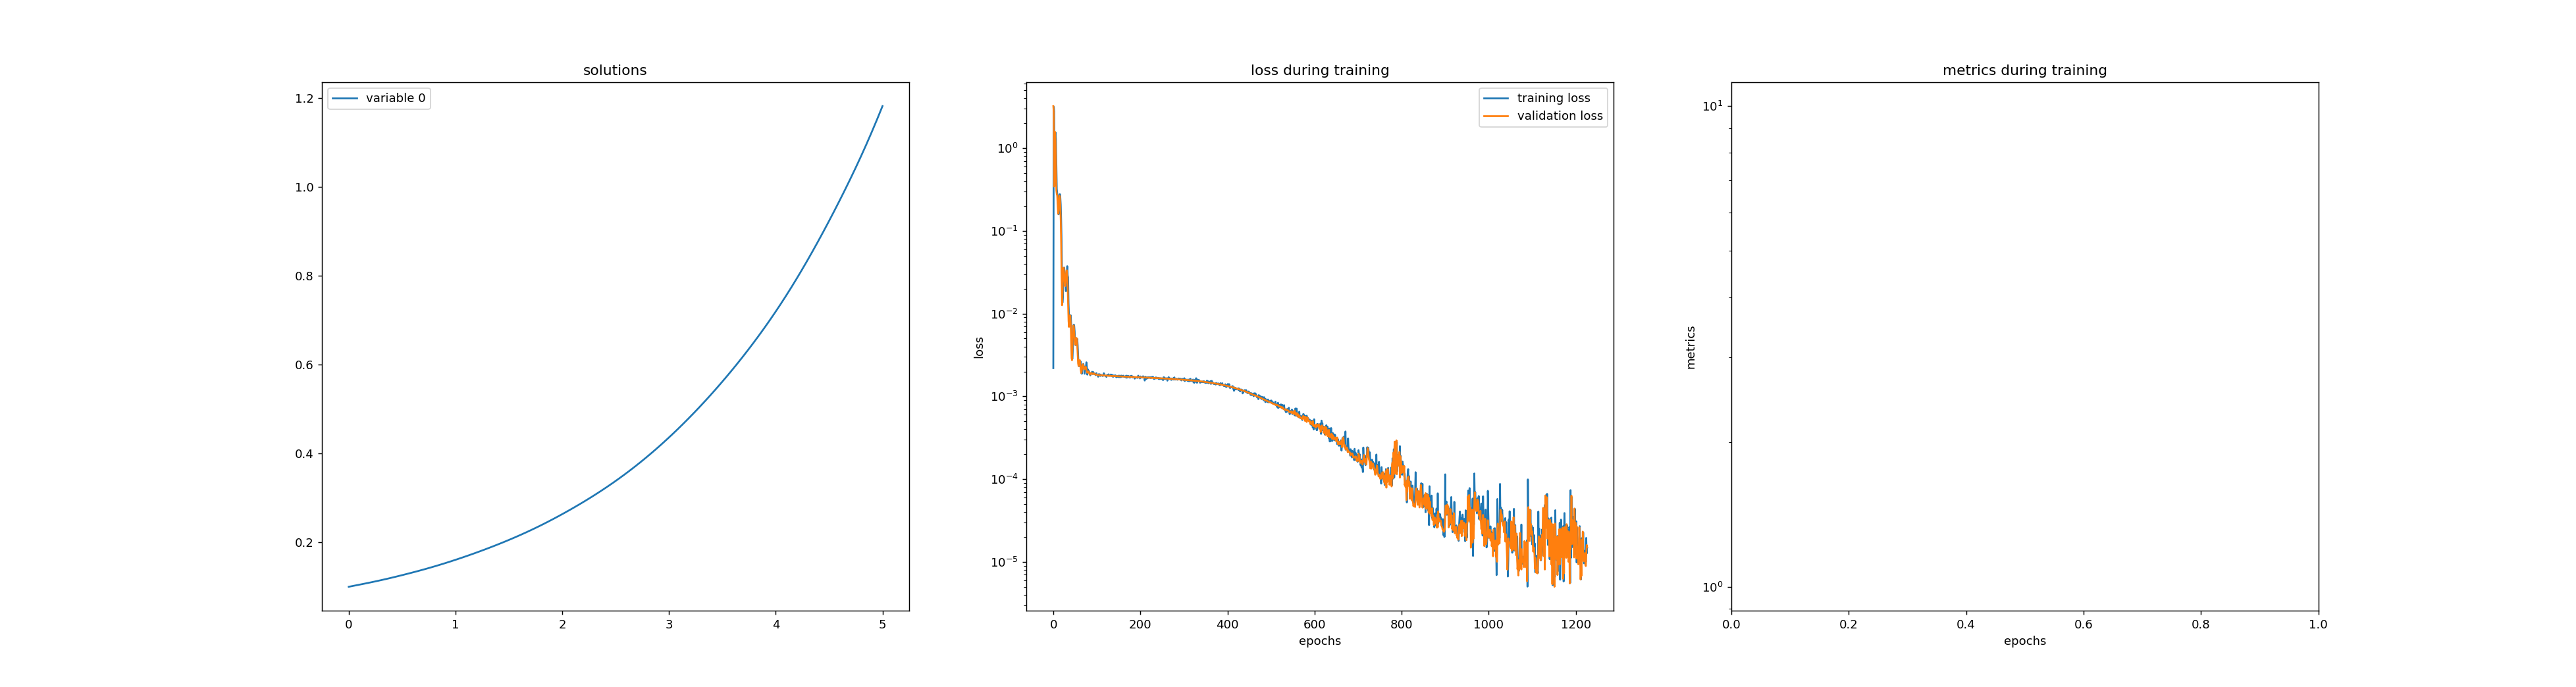

Training Progress:   0%|                               | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
%matplotlib notebook
monitor = Monitor1D(t_min=0.0, t_max=5.0, check_every=100)
monitor_callback = MonitorCallback(monitor)

solver_exponential.fit(max_epochs=2000, callbacks=[monitor_callback])
solution_exponential = solver_exponential.get_solution()